# RNN Training #
## Jackson Cornell ##

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## From feature_engineering.ipynb, delete later ##

fatal: destination path 'orchestral_samples' already exists and is not an empty directory.


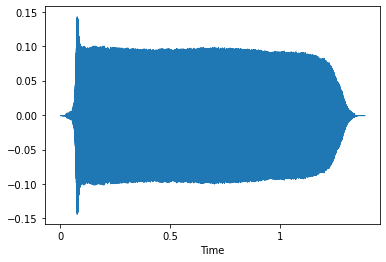

In [17]:
!pip install tensorflow-io
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import IPython
import soundfile as sf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
import tensorflow_io as tfio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

!git clone https://github.com/aesuf/orchestral_samples;
    
def trim_sample(y,sr,seconds):
  return librosa.util.fix_length(y,size=int((sr*seconds)))

def get_filenames():
  files = os.listdir('orchestral_samples/data')
  return list(
      map(
      lambda file: 'orchestral_samples/data/' + file , files)
  )

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def get_instruments():
  instruments = {
  "bass-clarinet": 0,
  "contrabassoon": 1,
  "cello": 2,
  "clarinet": 3,
  "bassoon": 4,
  "double-bass": 5,
  "french-horn": 6,
  "guitar": 7,
  "mandolin": 8,
  "oboe": 9,
  "saxophone": 10,
  "trombone": 11,
  "trumpet": 12,
  "tuba": 13,
  "viola": 14,
  "violin": 15,
}
  return instruments

def get_y_value(file):
  instruments = get_instruments()
  for instrument in instruments:
    if file.find(instrument)!=-1:
      return instruments[instrument]
  return "NULL"

def get_y_values():
  files = os.listdir('orchestral_samples/data')
  return np.array(
      list(
          map(get_y_value,files)
          )
      )
  
def get_labels():
  inv_map = {v: k for k, v in get_instruments().items()}
  return np.array(list(inv_map.items()))[:,[1]]

files = get_filenames()

i = np.random.randint(0,len(files)-1)
librosa.display.waveshow(*librosa.load(files[i]))

AUTOTUNE = tf.data.experimental.AUTOTUNE
def spectrogram(y):
  nfft=512
  window=512
  stride=256
  s = tfio.audio.spectrogram(y, nfft=nfft, window=window, stride=stride)
  s = tfio.audio.melscale(s, rate=22050, mels=128, fmin=0, fmax=11025)
  return tfio.audio.dbscale(s,top_db=80)   
def load_wav_22k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_samples=66000,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=22050)
    return wav
def process_feature(file_name):
  return spectrogram(load_wav_22k_mono(file_name))
dataset = (tf.data.Dataset.from_tensor_slices(get_filenames())
          .map(process_feature, num_parallel_calls=AUTOTUNE))
x = np.array([d.numpy() for d in dataset])

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    x, get_y_values(), test_size=0.33, random_state=42)

labels=get_labels()

y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

### Load data ###

In [18]:
'''
# load data

# split into training, validation, and test set
x_train, x_test, t_train, t_test = train_test_split(images, labels, test_size=0.20)
x_train, x_val, t_train, t_val = train_test_split(x_train, t_train, test_size=0.20)

# print sizes
print("Training data size:", x_train.shape)
print("Validation data size:", x_val.shape)
print("Testing data size:", x_test.shape)

# display data example
'''

'\n# load data\n\n# split into training, validation, and test set\nx_train, x_test, t_train, t_test = train_test_split(images, labels, test_size=0.20)\nx_train, x_val, t_train, t_val = train_test_split(x_train, t_train, test_size=0.20)\n\n# print sizes\nprint("Training data size:", x_train.shape)\nprint("Validation data size:", x_val.shape)\nprint("Testing data size:", x_test.shape)\n\n# display data example\n'

### Train model ###

In [20]:
# define model shape
input_shape=(129,128)
model = keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
#model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(24, activation='softmax'))
model.summary()

# compile model
model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['acc'])

# train model
history = model.fit(X_train, y_train, epochs=75, batch_size=72, validation_data=(X_test, y_test), shuffle=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               131584    
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 48)                6192      
                                                                 
 dropout_6 (Dropout)         (None, 48)                0         
                                                                 
 dense_16 (Dense)            (None, 24)                1176      
                                                                 
Total params: 155,464
Trainable params: 155,464
Non-tr

### Validate model ###

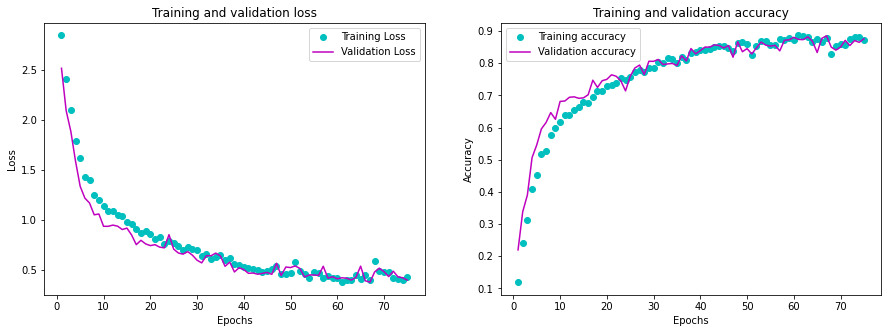

In [23]:
# display results
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['acc']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_acc']
epochs=range(1,76)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

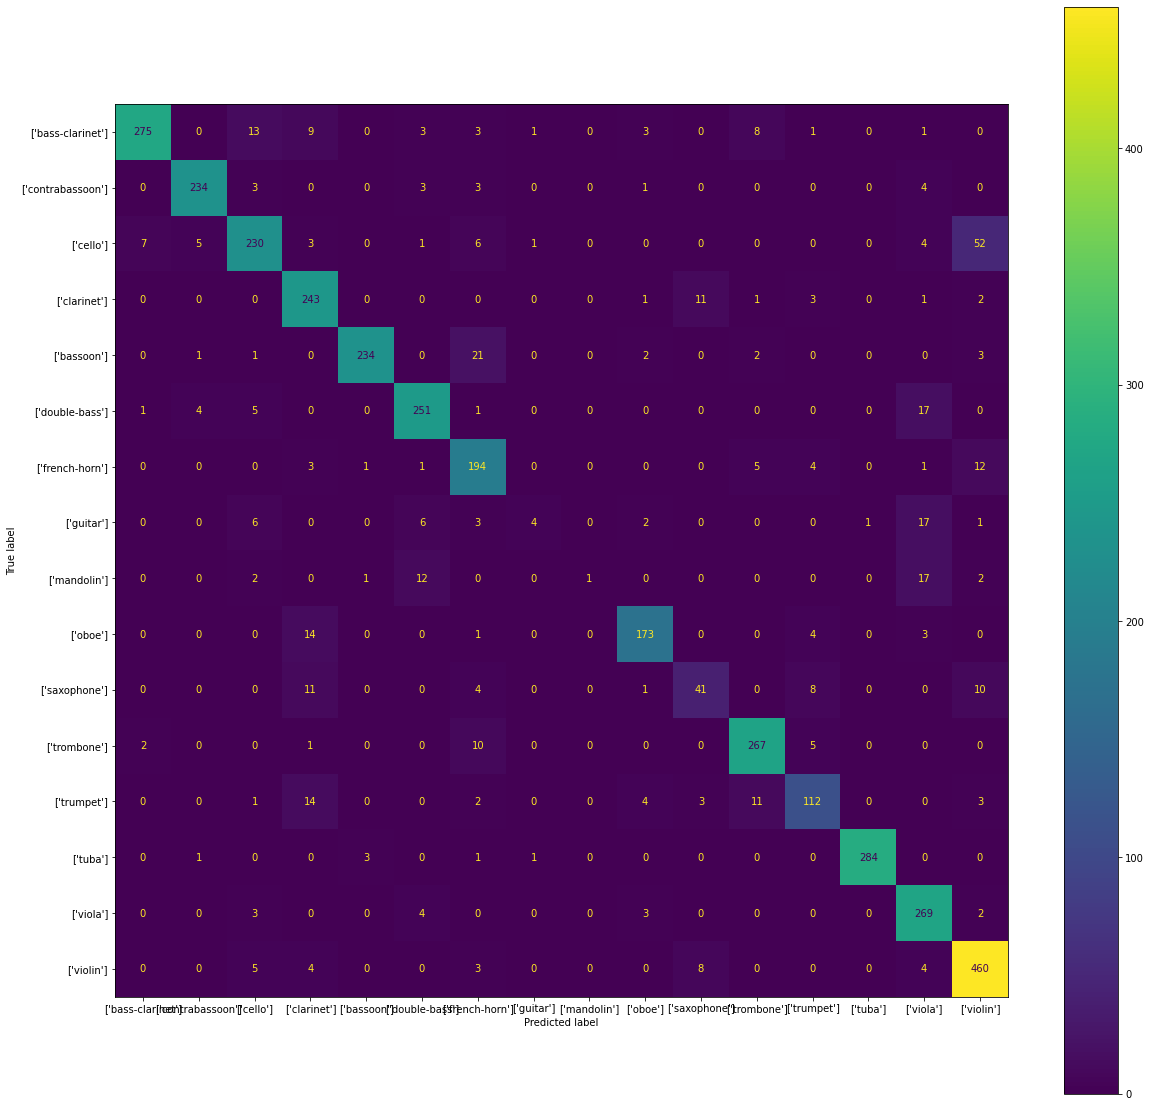

In [24]:
# display confusion matrix
y_pred = np.argmax(model.predict(X_test),axis = 1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax)
plt.show()

### Save model ###

In [ ]:
# uncomment when we start getting good results
#model.save('RNN_classifier')